In [1]:
#Importing required packages
from astropy.io import fits
from astropy.stats import sigma_clipped_stats as scs
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import linregress
from scipy.signal import savgol_filter
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
#Loading the data file
#lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211111_v1_level2.lc')
lc = fits.open(r'C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211013_v1_level2.lc')

In [3]:
lc.info()
#Information about data contained in the lc file

Filename: C:\Users\aswin\OneDrive\Desktop\ch2_xsm_20211013_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   80554R x 4C   [D, E, E, E]   


In [4]:
#Header of lc file primary
lc[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
MISSION = 'CHANDRAYAAN-2'      / Name of mission/satellite                      
TELESCOP= 'CH-2_ORBITER'       / Name of mission/satellite                      
INSTRUME= 'CH2_XSM '           / Name of Instrument/detector                    
ORIGIN  = 'PRLPOC  '           / Source of FITS file                            
CREATOR = 'xsmgenlc '          / Creator of file                                
FILENAME= 'ch2_xsm_20211013_v1_level2.lc' / Name of file                        
CONTENT = 'Light curve'     

In [5]:
#Header of lc file rate
lc[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                80554 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'ERROR   '        

Text(0, 0.5, 'Counts')

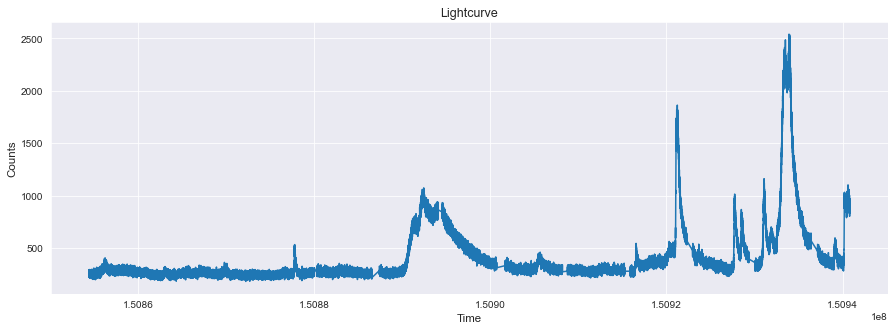

In [6]:
#Extracting count rates and time from the lc file
count_rate = lc['Rate'].data['Rate']
time = lc['Rate'].data['Time']
count_rate, time = np.array(count_rate), np.array(time)
plt.figure(0, figsize=(15,5))
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Counts',fontsize = 11.5)

Text(0, 0.5, 'Background subtracted counts')

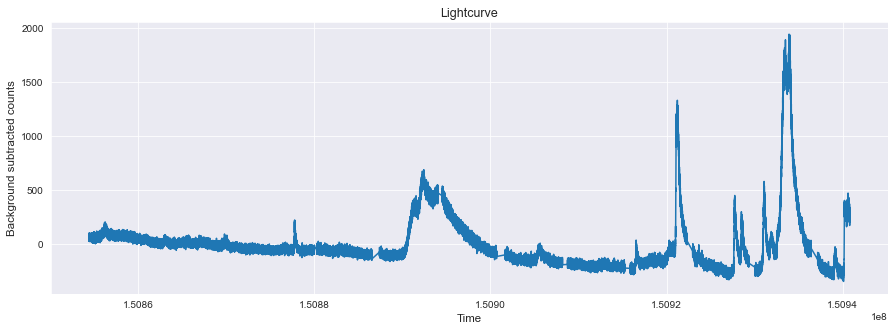

In [10]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(time, count_rate)
#bksub_counts = count_rate - np.array(slope*time+intercept)
count_rate = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
#plt.plot(time, bksub_counts)
plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

Text(0, 0.5, 'Boxcar smoothed counts')

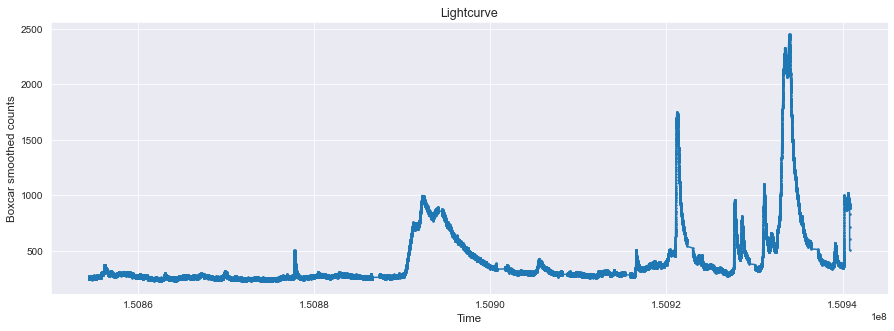

In [7]:
#box_car averaging
box_bin = 70
kernel_size = 8
box_time, box_count = np.array([]), np.array([])
for i in range(len(time[:])//box_bin):
    if(box_bin*i+i<=len(count_rate)):
        counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
        boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
        box_count = np.concatenate((box_count, boxavg_counts))
        box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
        #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
    else:
        continue
plt.figure(0, figsize=(15,5))
plt.plot(box_time, box_count, marker = '.', markersize = 3)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Boxcar smoothed counts',fontsize = 11.5)

Text(0, 0.5, 'Binned counts')

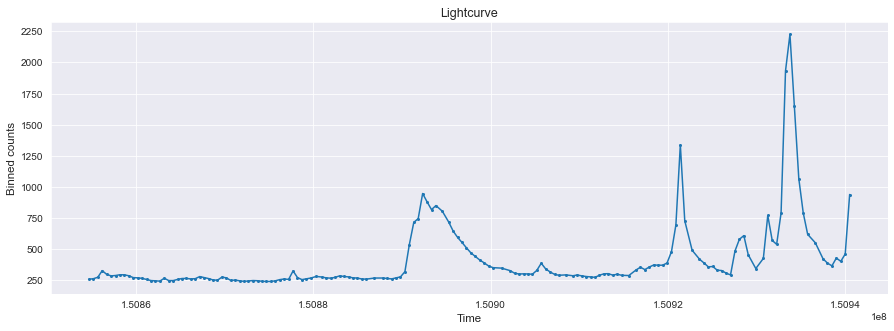

In [8]:
binned_time, binned_count = np.array([]), np.array([])
bin = 500
for i in range(len(box_time)//bin):
    binned_time = np.concatenate((binned_time, [(box_time[bin*i]+box_time[bin*(i+1)])/2]))
    binned_count = np.concatenate((binned_count, [np.average(box_count[bin*i:bin*(i+1)])]))
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, binned_count, marker = '.', markersize = 4)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Binned counts',fontsize = 11.5)

11.159733625590304
499
509


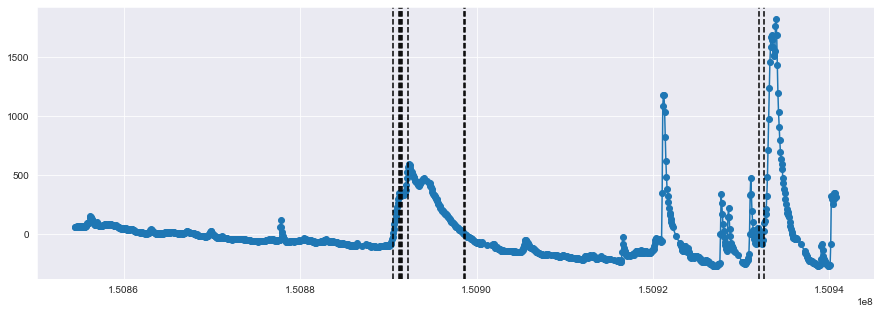

In [10]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-20:])
st_flags = np.where(np.divide(st_nr, st_dr)>st_cutoff)
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

#Peak of burst
peak = binned_count[st_flags[0][0]:]
pk_nr = peak[4:]
pk_dr = peak[:-4]
peak_flags = st_flags[0][0]+np.where(np.divide(pk_nr, pk_dr)<1)
print(peak_flags[0][0])

#End of burst
#zero_crossings = peak_flags[0][0]+np.where(np.where(np.diff(np.sign(np.divide(pk_nr, pk_dr)-1)))[0]>peak_flags[0][0])
#print(zero_crossings[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = 'o')

for i in range(min(len(st_flags[0]), len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')
    plt.axvline(binned_time[peak_flags[0][i]], color = 'black', ls='--')
#plt.axvline(binned_time[zero_crossings[0][10]], color = 'red', ls='--')

In [11]:
print(np.ediff1d(st_flags[0]))

[109   1 427   7]


In [12]:
print(st_flags)

(array([ 499,  608,  609, 1036, 1043], dtype=int64),)


0.3860292247299194
66


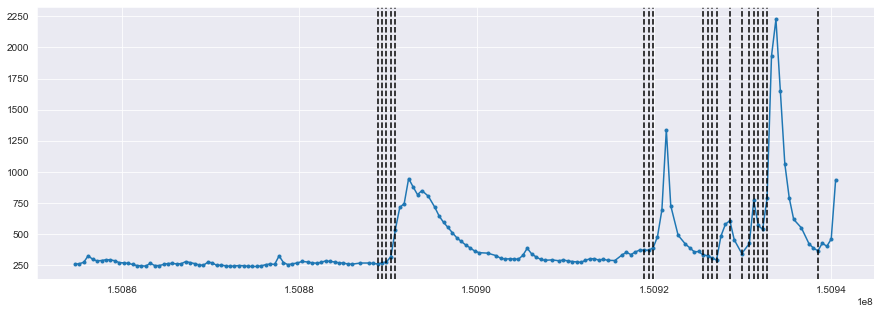

In [9]:
#Start of burst
st_nr = binned_count[4:]
st_dr = binned_count[:-4]
st_nr = st_nr - st_dr
st_dr = binned_time[4:] - binned_time[:-4]
st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-100:])
st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
print(np.average(np.sort(np.divide(st_nr, st_dr))[-10:]))
print(st_flags[0][0])

plt.figure(figsize = (15,5))
plt.plot(binned_time, binned_count,marker = '.')

for i in range(len(st_flags[0])):#, len(peak_flags[0]))):  
    plt.axvline(binned_time[st_flags[0][i]], color = 'black', ls='--')

Text(0, 0.5, 'Background subtracted counts')

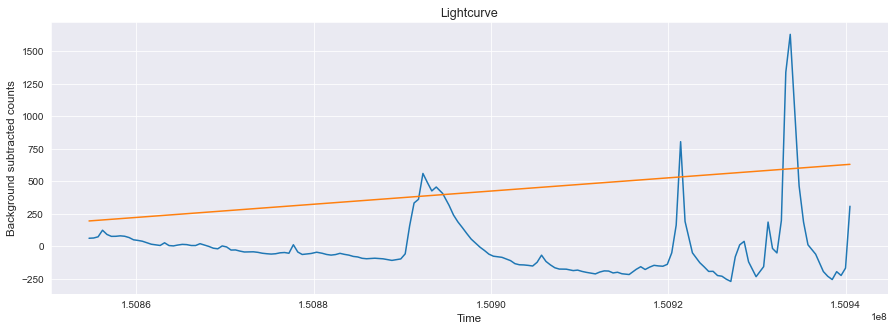

In [13]:
#Background subtraction
#Curvefit with a straight line
slope, intercept, r, p, se = linregress(binned_time, binned_count)
mean, med, sig = scs(binned_count)
binned_counts_masked = binned_count[np.where(binned_count>mean+0.5*sig)]
bksub_counts = binned_count - np.array(slope*binned_time+intercept)
#count_rate = count_rate - np.array(slope*time+intercept)
plt.figure(0, figsize=(15,5))
plt.plot(binned_time, bksub_counts)
plt.plot(binned_time, slope*binned_time+intercept)
#plt.plot(time, count_rate)
plt.title('Lightcurve', fontsize = 12.5)
plt.xlabel('Time', fontsize = 11.5)
plt.ylabel('Background subtracted counts',fontsize = 11.5)

In [17]:
diff = np.ediff1d(st_flags[0])
diff

array([169,   1,   1,   1,   1,   1,  14,   1,   1,   1, 310,   1,  63,
         1,   1,   1,   1,  81,   1,   1,   1,   9,   1,   1,   1,  22,
         1,   1,   1,   1,  10,  10,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   5,   1,   1,  62,   1,  14,   1,
         1,   1,   1], dtype=int64)

In [18]:
np.where(diff<5)

(array([ 1,  2,  3,  4,  5,  7,  8,  9, 11, 13, 14, 15, 16, 18, 19, 20, 22,
        23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 46, 47, 49, 51, 52, 53, 54], dtype=int64),)

In [12]:
def smooth(binsize = 70, kernelsize = 8):
    box_bin = binsize
    kernel_size = kernelsize
    box_time, box_count = np.array([]), np.array([])
    for i in range(len(time[:])//box_bin):
        print(i)
        if(box_bin*i+i<=len(count_rate)):
            counts = count_rate[box_bin*i+i:box_bin*(i+1)+kernel_size+1+i]
            boxavg_counts = convolve(counts, Box1DKernel(kernel_size))[kernel_size//2:box_bin+kernel_size//2+1]
            box_count = np.concatenate((box_count, boxavg_counts))
            box_time = np.concatenate((box_time, time[box_bin*i+i+kernel_size//2:box_bin*(i+1)+kernel_size//2+1+i]))
            #plt.plot(time[box_bin*i:box_bin*(i+1)+kernel_size+1], counts, marker = '.', markersize = 3, alpha = 0.1)
        else:
            continue
    return box_time, box_count

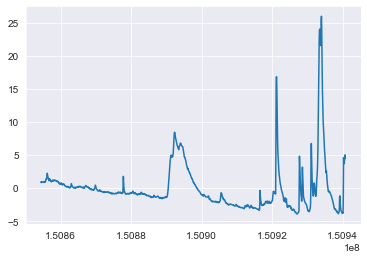

In [14]:
plt.plot(binned_time,binned_count/bin)
plt.show()

0.8446028746650845 157923910.23080263
1.1839883926472972
[1.42406387e-07 1.41999368e-07 1.41539062e-07 ... 4.71076735e-07
 3.88502035e-07 3.12108275e-07]


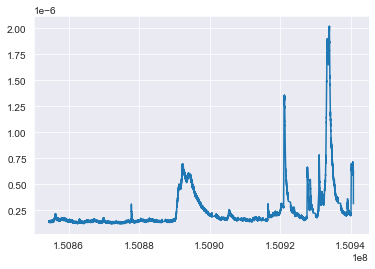

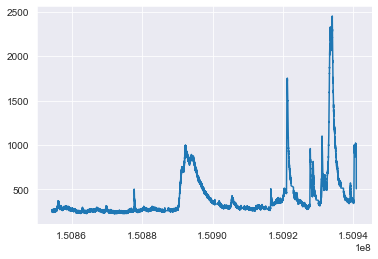

In [37]:
start_energy_flux=np.log10(3e-9)
start_count_rate=np.log10(1e1)
end_energy_flux=np.log10(7e-7)
end_count_rate=np.log10(1e3)
flux_slope=((end_count_rate-start_count_rate)/(end_energy_flux-start_energy_flux))
A = np.power(10, start_count_rate - flux_slope*start_energy_flux)
print(flux_slope, A)
print(1/flux_slope)
flux = np.power(np.array(box_count/A), 1/flux_slope)
print(flux)
plt.plot(box_time,flux)
plt.figure()
plt.plot(box_time,box_count)
class_A=1e-8
class_B=1e-7

In [ ]:
def n_sigma(time, counts, n):
    '''n-sigma : returns indices where counts>(mean+n*sigma)
    Returns flags, mean, sigma'''
    mean,_, sigma = scs(counts)
    #flags = np.where(counts>(mean+n*sigma)
    flags = np.where(counts>(mean+n*sigma))
    return flags, mean, sigma

def local_maxima(time, rates):
    #Start of burst
    st_nr = binned_count[4:]
    st_dr = binned_count[:-4]
    st_nr = st_nr - st_dr
    st_dr = binned_time[4:] - binned_time[:-4]
    st_cutoff = np.average(np.sort(np.divide(st_nr, st_dr))[-200:])
    st_flags = np.array(np.where(np.divide(st_nr, st_dr)>st_cutoff))
    return st_flags

def ns(self, time, rates):
    background_corrected_counts = self.bg_correction(time, rates)
    bin_time, bin_rates = self.rebin_lc(time, background_corrected_counts, 1.0, 25.0)
    flags, mean, sigma = n_sigma(bin_time, bin_rates, 3)
    return flags

def lm(self, time, rates):
    background_corrected_counts = self.bg_correction(time, rates)
    box_time, box_rates = self.smoothen(time, background_corrected_counts, 70, 8)
    bin_time, bin_rates = self.rebin_lc(box_time, box_rates, 1.0, 70.0)
    flags = local_maxima(bin_time, bin_rates)
    return flags

flags2 = np.arange(581, 628)

def EFP(x, A, B, C, D):
    Z = (2*B + C**2*D)/(2*C)
    return 1/2 * np.sqrt(np.pi) *  A * C * np.exp(D*(B-x) + C**2*D**2/4) * (erf(Z) - erf(Z - x/C))

def efp(self, time, rates):
    popt, pcov = curve_fit(EFP, np.float128(time[flags2]), np.float128(rates[flags2]), p0 =([25, 6000+1.5337e8, 17, 0.1]))
    #x2 = np.arange(1.533e8+75000, 1.533e8+77000)
    x2 = np.arange(1.533e8+74000, 1.533e8+78000)
    plt.scatter(time_new[flags2], counts_new[flags2])
    plt.plot(x2, EFP(x2, *popt))
    plt.savefig("efp_fit_1.png")

In [2]:
from scipy.optimize import curve_fit